# Sensitivity Analysis Script

> **Transparency Note:** This notebook reports an analysis conducted as part of the **peer review** an article reporting the work.  **In summary, the findings of this sensitivity analysis do not alter the conclusions of our study. We were not able to replicate the results report, and there were no errors in the model generated using the LLM.** 

During the peer review of this work for the Journal of Simulation, a reviewer asked us to conduct a sensitivity analysis. This was because the results of our CCU model were different from the original journal article. There was a possibility that small changes in the parameters may calibrate the results between our recreation and the original model.

During our study there were three key sources of uncertainty in the reporting of the model:

1. The empirical distribution of elective inter-arrival times is not provided.
2. The empirical distribution (resampling of raw data) for elective length of stay in the CCU is not provided.
3. A&E, Ward, and Emergency Surgery patients length of stay are reported to fit both a Lognormal (parameters available) and n-stage HyperExponential (parameters unavailable) distributions.  

## Summary of analysis conducted

In response, we performed three types of analysis:

### One-way analysis of elective operations inter-arrival mean

In the original study the elective arrival process was modelled as an empirical distribution.  We could not determine if original model resampled the raw data directly or if an empirical distribution was constructed. An image of a relative frequency histogram of the elective arrivals is provided in the text, but the raw data behind it are not available. The authors state that a Normal Distribution with mean 17.91 and stdev 3.16 could be used as an alternative and we were unclear if this was the actual approach used in the original model or if the empirical distribution was indeed used.  The authors also state an expected number of elective patients at approximately 30 per month - or 360 per year (i.e. approximately 1 patient per day).

When implemented in our model this resulted in an average of 1650 arrivals in total (n = 5 replications). This is in line with expectations for the parameters available in the original journal article. See table below. Note that the number of elective patients is higher than the 360 expected.  

| **Source**          | **IAT** | **Rate/day** | **Rate/year** |
|---------------------|---------|--------------|---------------|
| A&E                 | 22.72   | 1.06         | 385.56        |
| Ward                | 26.00   | 0.92         | 336.92        |
| Emergency           | 37.00   | 0.65         | 236.76        |
| Other hospital      | 47.20   | 0.51         | 185.59        |
| X-ray               | 575.00  | 0.04         | 15.23         |
| **Unplanned Total** |         |              | **1160.07**   |
| Electives           | 17.91   | 1.34         | 489.11        |
| **Expected demand** |         |              | **1649.2**    |

The original article quotes an annual number of **admissions** as 1341 and in a 24 bed scenario a total of 57 elective cancellations. If we are distinguishing between arrivals and admissions this gives a total number of arrivals of approximately 1400 i.e. 250 less than the parameters we have included.  

To explore this issue, we examined the one-way sensitivity of the model to mean of the Normal distribution used. The result is that to get to the required number of arrivals the mean inter-arrival time is required to be approximately doubled.e. to over 35 hours.

### One-way analysis of Length of Stay means for A&E, Ward, Emergency, and Elective Patients

The authors state that they chose Lognormal distributions for Length of Stay for A&E, Ward, and Emergency, but also that 3 and 4 stage HyperExponential distributions fit.  They authors only provide mean and stdev and not the parameters of the HyperExponential. We therefore chose to use Lognormals in our recreation.  In the article Elective LoS is modelled by resampling from the raw data, but these data are not provided as supplementary material. However, the mean and standard deviation is provided. We therefore opted to use a Lognormal again.  We varied the mean of these distribution by +- 50%.  Our conclusions remained the same. The results were not reproduced.


### Two way analysis of elective parameters

We simultaneously varied elective inter-arrival times (20 up to 55 hrs) and elective LoS mean (+- 30).  The model is sensitive to an simultaneous increase in elective IAT and reduction in LoS.  But it does not get close to replicating results within reasonable values.  For example, elective operations are still above 100 with a doubled IAT. We suspect the main issue here is the shape of the distributions chosen.  Our conclusion is that the lognormal distribution is a poor fit for elective length stay.


## General imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from itertools import product

## Model imports

In [2]:
from ccu_formatted_code import (
    Experiment,
    multiple_replications,
    results_summary,
    get_experiments,
    run_all_experiments,
    summary_of_experiments,
)

## Analysis 1: A one-way sensitivity analysis of elective arrivals

In [3]:
def run_sensitivity_analysis():
    """
    Run sensitivity analysis on elective inter-arrival time
    """
    # Define the range of elective inter-arrival times
    elective_iat_values = list(range(20, 51, 5))  # [20, 25, 30, 35]

    # Store results for each experiment
    sensitivity_results = []

    print("Starting sensitivity analysis...")

    # Run the model for each elective inter-arrival time
    for i, iat in enumerate(elective_iat_values):
        print(
            f"Running experiment {i+1}/{len(elective_iat_values)}: Elective IAT = {iat} hours"
        )

        # Create experiment with 24 beds and updated elective inter-arrival time
        # Index 5 in interarrival_means corresponds to elective surgery
        interarrival_means = [22.72, 26.0, 37.0, 47.2, 575.0, iat]

        experiment = Experiment(
            num_critical_care_beds=24, interarrival_means=interarrival_means
        )

        # Run 100 replications
        replications = multiple_replications(experiment, num_replications=100)

        # Summarize results
        summary = results_summary(replications)

        # Add the elective IAT value to the summary
        summary_dict = {
            "Elective_IAT": iat,
            "Cancelled_Elective_Operations_Mean": summary.loc[
                "Cancelled Elective Operations", "Mean"
            ],
            "Cancelled_Elective_Operations_Std": summary.loc[
                "Cancelled Elective Operations", "Standard Deviation"
            ],
            "Bed_Occupancy_Mean": summary.loc["Bed Occupancy", "Mean"],
            "Bed_Occupancy_Std": summary.loc["Bed Occupancy", "Standard Deviation"],
            "Patient_Count_Mean": summary.loc["Patient Count", "Mean"],
            "Patient_Count_Std": summary.loc["Patient Count", "Standard Deviation"],
            "Bed_Utilization_Mean": summary.loc["Bed Utilization", "Mean"],
            "Bed_Utilization_Std": summary.loc["Bed Utilization", "Standard Deviation"],
            "Mean_Waiting_Time_Unplanned_Mean": summary.loc[
                "Mean Waiting Time Unplanned", "Mean"
            ],
            "Mean_Waiting_Time_Unplanned_Std": summary.loc[
                "Mean Waiting Time Unplanned", "Standard Deviation"
            ],
        }

        sensitivity_results.append(summary_dict)

    # Convert to DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results)

    print("Sensitivity analysis complete!")
    return sensitivity_df


def create_sensitivity_charts(sensitivity_df):
    """
    Create three charts showing sensitivity analysis results
    """
    # Griffith's reference values
    griffith_cancelled_ops = 57
    griffith_bed_occupancy = 19.76
    griffith_patient_count = 1400

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        "Sensitivity Analysis: Elective Inter-Arrival Time",
        fontsize=16,
        fontweight="bold",
    )

    # Chart 1: Cancelled Elective Operations
    axes[0].plot(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Cancelled_Elective_Operations_Mean"],
        "bo-",
        linewidth=2,
        markersize=8,
    )
    axes[0].fill_between(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Cancelled_Elective_Operations_Mean"]
        - sensitivity_df["Cancelled_Elective_Operations_Std"],
        sensitivity_df["Cancelled_Elective_Operations_Mean"]
        + sensitivity_df["Cancelled_Elective_Operations_Std"],
        alpha=0.3,
    )
    axes[0].axhline(
        y=griffith_cancelled_ops,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Griffith's result",
    )
    axes[0].set_xlabel("Elective Inter-Arrival Time (hrs)")
    axes[0].set_ylabel("Cancelled Elective Operations")
    axes[0].set_title("Cancelled Elective Operations")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Chart 2: Bed Occupancy
    axes[1].plot(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Bed_Occupancy_Mean"],
        "go-",
        linewidth=2,
        markersize=8,
    )
    axes[1].fill_between(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Bed_Occupancy_Mean"] - sensitivity_df["Bed_Occupancy_Std"],
        sensitivity_df["Bed_Occupancy_Mean"] + sensitivity_df["Bed_Occupancy_Std"],
        alpha=0.3,
    )
    axes[1].axhline(
        y=griffith_bed_occupancy,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Griffith's result",
    )
    axes[1].set_xlabel("Elective Inter-Arrival Time (hrs)")
    axes[1].set_ylabel("Bed Occupancy")
    axes[1].set_title("Bed Occupancy")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Chart 3: Patient Count
    axes[2].plot(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Patient_Count_Mean"],
        "mo-",
        linewidth=2,
        markersize=8,
    )
    axes[2].fill_between(
        sensitivity_df["Elective_IAT"],
        sensitivity_df["Patient_Count_Mean"] - sensitivity_df["Patient_Count_Std"],
        sensitivity_df["Patient_Count_Mean"] + sensitivity_df["Patient_Count_Std"],
        alpha=0.3,
    )
    axes[2].axhline(
        y=griffith_patient_count,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Griffith's result",
    )
    axes[2].set_xlabel("Elective Inter-Arrival Time (hrs)")
    axes[2].set_ylabel("Patient Count")
    axes[2].set_title("Patient Count")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return fig

In [4]:
# Run sensitivity analysis
sensitivity_results = run_sensitivity_analysis()

# Display results table
print("\n" + "=" * 80)
print("SENSITIVITY ANALYSIS RESULTS")
print("=" * 80)
sensitivity_results.round(2)

Starting sensitivity analysis...
Running experiment 1/7: Elective IAT = 20 hours
Running experiment 2/7: Elective IAT = 25 hours
Running experiment 3/7: Elective IAT = 30 hours
Running experiment 4/7: Elective IAT = 35 hours
Running experiment 5/7: Elective IAT = 40 hours
Running experiment 6/7: Elective IAT = 45 hours
Running experiment 7/7: Elective IAT = 50 hours
Sensitivity analysis complete!

SENSITIVITY ANALYSIS RESULTS


,Elective_IAT,Cancelled_Elective_Operations_Mean,Cancelled_Elective_Operations_Std,Bed_Occupancy_Mean,Bed_Occupancy_Std,Patient_Count_Mean,Patient_Count_Std,Bed_Utilization_Mean,Bed_Utilization_Std,Mean_Waiting_Time_Unplanned_Mean,Mean_Waiting_Time_Unplanned_Std
0,20,259.14,67.54,21.31,0.80,1576.71,35.20,0.89,0.03,46.88,51.47
1,25,200.07,56.03,21.13,0.86,1490.40,35.34,0.88,0.04,45.81,50.87
2,30,161.82,47.69,21.00,0.90,1432.85,35.22,0.88,0.04,45.31,51.03
3,35,135.65,41.89,20.90,0.94,1391.75,35.22,0.87,0.04,44.77,50.82
4,40,116.77,36.80,20.83,0.97,1361.08,35.19,0.87,0.04,44.62,51.15
5,45,102.59,33.27,20.76,0.99,1337.03,35.23,0.86,0.04,44.43,51.76
6,50,91.92,30.00,20.71,1.01,1317.75,35.25,0.86,0.04,44.19,51.25



Creating sensitivity charts...


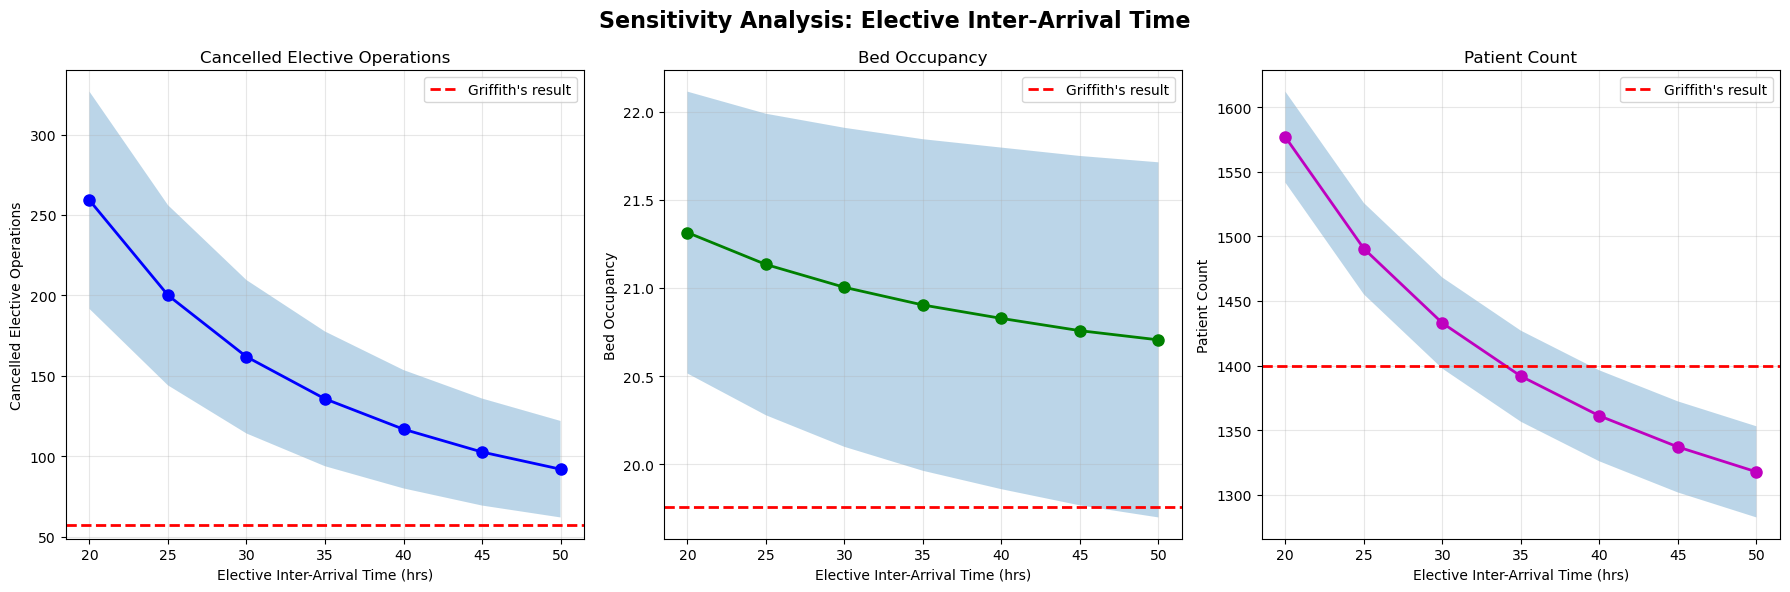


Results saved to 'sensitivity_analysis_results.csv'
Charts saved to 'sensitivity_analysis_charts.png'


In [5]:
# Create and display charts
print("\nCreating sensitivity charts...")
fig = create_sensitivity_charts(sensitivity_results)

# Save results to CSV
sensitivity_results.to_csv("sensitivity_analysis_results.csv", index=False)
print("\nResults saved to 'sensitivity_analysis_results.csv'")

# Save charts
fig.savefig("sensitivity_analysis_charts.png", dpi=300, bbox_inches="tight")
print("Charts saved to 'sensitivity_analysis_charts.png'")

## Analysis 2: One-way analysis of length of stay (tornado plots)

In [6]:
def length_of_stay_sensitivity_parameters():
    """
    Define the length of stay parameters and their ranges for sensitivity analysis
    Focus on A&E, Ward, Emergency surgery, and Elective surgery length of stay means
    """
    # Base case parameters
    base_params = {
        "interarrival_means": [22.72, 26.0, 37.0, 47.2, 575.0, 17.91],
        "stay_distributions": [
            (128.79, 267.51),  # A&E - index 0
            (177.89, 276.54),  # Ward - index 1
            (140.15, 218.02),  # Emergency surgery - index 2
            (212.86, 457.67),  # Other hospitals - index 3
            (87.53, 108.67),  # X-ray - index 4
            57.34,  # Elective surgery - index 5 (not used in stay_distributions)
        ],
        "num_critical_care_beds": 24,
        "intensive_cleaning_duration": 5,
        "elective_treatment_mean": 57.34,  # Elective surgery LOS mean
    }

    # Parameter ranges for sensitivity analysis (±25% variation in mean length of stay)
    param_ranges = {
        "AE_LOS_mean": [
            base_params["stay_distributions"][0][0] * 0.75,
            base_params["stay_distributions"][0][0] * 1.25,
        ],  # 96.6 to 160.99
        "Ward_LOS_mean": [
            base_params["stay_distributions"][1][0] * 0.75,
            base_params["stay_distributions"][1][0] * 1.25,
        ],  # 133.4 to 222.4
        "Emergency_LOS_mean": [
            base_params["stay_distributions"][2][0] * 0.75,
            base_params["stay_distributions"][2][0] * 1.25,
        ],  # 105.1 to 175.2
        "Elective_LOS_mean": [
            base_params["elective_treatment_mean"] * 0.75,
            base_params["elective_treatment_mean"] * 1.25,
        ],  # 43.0 to 71.7
    }

    return base_params, param_ranges


def create_experiment_with_los_param(base_params, param_name, value):
    """Helper function to create experiment with modified length of stay parameter"""
    params = base_params.copy()
    new_stay_distributions = list(params["stay_distributions"])

    if param_name == "AE_LOS_mean":
        # Modify A&E length of stay mean, keep std deviation same
        new_stay_distributions[0] = (value, params["stay_distributions"][0][1])
    elif param_name == "Ward_LOS_mean":
        # Modify Ward length of stay mean, keep std deviation same
        new_stay_distributions[1] = (value, params["stay_distributions"][1][1])
    elif param_name == "Emergency_LOS_mean":
        # Modify Emergency surgery length of stay mean, keep std deviation same
        new_stay_distributions[2] = (value, params["stay_distributions"][2][1])
    elif param_name == "Elective_LOS_mean":
        # Modify Elective surgery length of stay mean
        params["elective_treatment_mean"] = value

    params["stay_distributions"] = new_stay_distributions

    return Experiment(
        interarrival_means=params["interarrival_means"],
        stay_distributions=params["stay_distributions"],
        num_critical_care_beds=params["num_critical_care_beds"],
        intensive_cleaning_duration=params["intensive_cleaning_duration"],
        elective_treatment_mean=params["elective_treatment_mean"],
    )


def los_sensitivity_analysis(base_params, param_ranges, num_replications=100):
    """
    Conduct sensitivity analysis on length of stay parameters including elective
    """
    results = []

    # Base case
    print("Running base case...")
    base_experiment = Experiment(
        interarrival_means=base_params["interarrival_means"],
        stay_distributions=base_params["stay_distributions"],
        num_critical_care_beds=base_params["num_critical_care_beds"],
        intensive_cleaning_duration=base_params["intensive_cleaning_duration"],
        elective_treatment_mean=base_params["elective_treatment_mean"],
    )

    base_results = multiple_replications(base_experiment, num_replications)
    base_summary = results_summary(base_results)

    # Store base case
    base_case = {
        "Parameter": "Base Case",
        "Value": "Base",
        "LOS_Value": "Base",
        "Cancelled_Ops": base_summary.loc["Cancelled Elective Operations", "Mean"],
        "Cancelled_Ops_Std": base_summary.loc[
            "Cancelled Elective Operations", "Standard Deviation"
        ],
        "Bed_Occupancy": base_summary.loc["Bed Occupancy", "Mean"],
        "Bed_Occupancy_Std": base_summary.loc["Bed Occupancy", "Standard Deviation"],
        "Bed_Utilization": base_summary.loc["Bed Utilization", "Mean"],
        "Bed_Utilization_Std": base_summary.loc[
            "Bed Utilization", "Standard Deviation"
        ],
        "Wait_Time": base_summary.loc["Mean Waiting Time Unplanned", "Mean"],
        "Wait_Time_Std": base_summary.loc[
            "Mean Waiting Time Unplanned", "Standard Deviation"
        ],
        "Patient_Count": base_summary.loc["Patient Count", "Mean"],
        "Patient_Count_Std": base_summary.loc["Patient Count", "Standard Deviation"],
    }
    results.append(base_case)

    # Test each length of stay parameter
    for param_name, (low_val, high_val) in param_ranges.items():
        print(f"Testing {param_name}...")

        # Test low value
        low_experiment = create_experiment_with_los_param(
            base_params, param_name, low_val
        )
        low_results = multiple_replications(low_experiment, num_replications)
        low_summary = results_summary(low_results)

        # Test high value
        high_experiment = create_experiment_with_los_param(
            base_params, param_name, high_val
        )
        high_results = multiple_replications(high_experiment, num_replications)
        high_summary = results_summary(high_results)

        # Store results
        for label, summary, value in [
            ("Low", low_summary, low_val),
            ("High", high_summary, high_val),
        ]:
            result = {
                "Parameter": param_name,
                "Value": f"{label}",
                "LOS_Value": f"{value:.1f}",
                "Cancelled_Ops": summary.loc["Cancelled Elective Operations", "Mean"],
                "Cancelled_Ops_Std": summary.loc[
                    "Cancelled Elective Operations", "Standard Deviation"
                ],
                "Bed_Occupancy": summary.loc["Bed Occupancy", "Mean"],
                "Bed_Occupancy_Std": summary.loc["Bed Occupancy", "Standard Deviation"],
                "Bed_Utilization": summary.loc["Bed Utilization", "Mean"],
                "Bed_Utilization_Std": summary.loc[
                    "Bed Utilization", "Standard Deviation"
                ],
                "Wait_Time": summary.loc["Mean Waiting Time Unplanned", "Mean"],
                "Wait_Time_Std": summary.loc[
                    "Mean Waiting Time Unplanned", "Standard Deviation"
                ],
                "Patient_Count": summary.loc["Patient Count", "Mean"],
                "Patient_Count_Std": summary.loc["Patient Count", "Standard Deviation"],
            }
            results.append(result)

    return pd.DataFrame(results)


def create_los_tornado_plots(sensitivity_df):
    """
    Create tornado plots for length of stay sensitivity analysis including elective
    """
    # Get base case values
    base_row = sensitivity_df[sensitivity_df["Parameter"] == "Base Case"].iloc[0]
    base_values = {
        "Cancelled_Ops": base_row["Cancelled_Ops"],
        "Bed_Occupancy": base_row["Bed_Occupancy"],
        "Bed_Utilization": base_row["Bed_Utilization"],
        "Wait_Time": base_row["Wait_Time"],
        "Patient_Count": base_row["Patient_Count"],
    }

    # Create tornado plot data
    tornado_data = []
    parameters = [p for p in sensitivity_df["Parameter"].unique() if p != "Base Case"]

    for param in parameters:
        param_data = sensitivity_df[sensitivity_df["Parameter"] == param]
        low_data = param_data[param_data["Value"] == "Low"].iloc[0]
        high_data = param_data[param_data["Value"] == "High"].iloc[0]

        for metric in base_values.keys():
            low_effect = low_data[metric] - base_values[metric]
            high_effect = high_data[metric] - base_values[metric]

            tornado_data.append(
                {
                    "Parameter": param.replace("_", " ").replace(
                        "LOS", "Length of Stay"
                    ),
                    "Metric": metric,  # Keep original metric name for filtering
                    "Low_Effect": low_effect,
                    "High_Effect": high_effect,
                    "Total_Effect": abs(high_effect - low_effect),
                    "Base_Value": base_values[metric],
                    "Low_Value": low_data[metric],
                    "High_Value": high_data[metric],
                }
            )

    tornado_df = pd.DataFrame(tornado_data)

    # Create subplots for different metrics
    metrics = [
        "Cancelled_Ops",
        "Bed_Occupancy",
        "Bed_Utilization",
        "Wait_Time",
        "Patient_Count",
    ]
    metric_titles = [
        "Cancelled Elective Operations",
        "Bed Occupancy",
        "Bed Utilization",
        "Mean Waiting Time (Unplanned)",
        "Patient Count",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        if i < len(axes):
            ax = axes[i]

            # Filter data for this metric
            metric_data = tornado_df[tornado_df["Metric"] == metric].copy()

            # Check if we have data for this metric
            if len(metric_data) == 0:
                print(f"Warning: No data found for metric {metric}")
                ax.text(
                    0.5,
                    0.5,
                    f"No data for {title}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                )
                continue

            # Sort by total effect
            metric_data = metric_data.sort_values("Total_Effect", ascending=True)

            y_pos = np.arange(len(metric_data))

            # Get base value for this metric
            base_value = metric_data.iloc[0]["Base_Value"]

            # Create bars
            for j, (_, row) in enumerate(metric_data.iterrows()):
                # Left bar (low effect)
                left_width = abs(row["Low_Effect"])
                left_start = (
                    base_value - left_width if row["Low_Effect"] < 0 else base_value
                )

                # Right bar (high effect)
                right_width = abs(row["High_Effect"])
                right_start = (
                    base_value if row["High_Effect"] > 0 else base_value - right_width
                )

                # Plot bars
                ax.barh(
                    j,
                    left_width,
                    left=left_start,
                    height=0.6,
                    color="lightcoral",
                    alpha=0.7,
                    label="Low (-25%)" if j == 0 else "",
                )
                ax.barh(
                    j,
                    right_width,
                    left=right_start,
                    height=0.6,
                    color="lightblue",
                    alpha=0.7,
                    label="High (+25%)" if j == 0 else "",
                )

            # Add base line
            ax.axvline(
                base_value, color="black", linestyle="--", alpha=0.7, label=f"Base Case"
            )

            # Formatting
            ax.set_yticks(y_pos)
            ax.set_yticklabels(metric_data["Parameter"])
            ax.set_xlabel(f"{title}")
            ax.set_title(f"Sensitivity: {title}", fontsize=12, fontweight="bold")
            ax.legend(fontsize=8)
            ax.grid(axis="x", alpha=0.3)

    # Remove unused subplot
    if len(metrics) < len(axes):
        axes[-1].remove()

    plt.suptitle(
        "Length of Stay Sensitivity Analysis: Tornado Plots (Including Elective)",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()
    return fig


def run_los_sensitivity_analysis():
    """
    Run complete length of stay sensitivity analysis including elective
    """
    print("Starting Length of Stay Sensitivity Analysis...")
    print("Focusing on A&E, Ward, Emergency, and Elective surgery length of stay means")

    # Get parameters
    base_params, param_ranges = length_of_stay_sensitivity_parameters()

    # Display parameter information
    print("\nBase case length of stay means:")
    print(f"A&E: {base_params['stay_distributions'][0][0]:.1f} hours")
    print(f"Ward: {base_params['stay_distributions'][1][0]:.1f} hours")
    print(f"Emergency: {base_params['stay_distributions'][2][0]:.1f} hours")
    print(f"Elective: {base_params['elective_treatment_mean']:.1f} hours")

    print("\nTesting ranges (±25%):")
    for param_name, (low_val, high_val) in param_ranges.items():
        print(f"{param_name}: {low_val:.1f} to {high_val:.1f} hours")

    # Run sensitivity analysis
    sensitivity_results = los_sensitivity_analysis(
        base_params, param_ranges, num_replications=100
    )

    # Display results table
    print("\n" + "=" * 80)
    print("LENGTH OF STAY SENSITIVITY ANALYSIS RESULTS (INCLUDING ELECTIVE)")
    print("=" * 80)

    # Create summary table
    summary_cols = [
        "Parameter",
        "Value",
        "LOS_Value",
        "Cancelled_Ops",
        "Bed_Occupancy",
        "Bed_Utilization",
        "Wait_Time",
        "Patient_Count",
    ]
    print(sensitivity_results[summary_cols].round(2))

    # Create tornado plots
    print("\nCreating tornado plots...")
    fig = create_los_tornado_plots(sensitivity_results)
    plt.show()

    # Save results
    sensitivity_results.to_csv(
        "los_sensitivity_analysis_with_elective_results.csv", index=False
    )
    fig.savefig("los_tornado_plots_with_elective.png", dpi=300, bbox_inches="tight")

    print("\nAnalysis complete!")
    print("Results saved to 'los_sensitivity_analysis_with_elective_results.csv'")
    print("Tornado plots saved to 'los_tornado_plots_with_elective.png'")

    return sensitivity_results


# Additional function to create a comparison table


def create_los_comparison_table(sensitivity_results):
    """
    Create a comparison table showing the effect of each LOS parameter
    """
    base_row = sensitivity_results[
        sensitivity_results["Parameter"] == "Base Case"
    ].iloc[0]

    comparison_data = []
    parameters = [
        p for p in sensitivity_results["Parameter"].unique() if p != "Base Case"
    ]

    for param in parameters:
        param_data = sensitivity_results[sensitivity_results["Parameter"] == param]
        low_data = param_data[param_data["Value"] == "Low"].iloc[0]
        high_data = param_data[param_data["Value"] == "High"].iloc[0]

        comparison_data.append(
            {
                "Parameter": param.replace("_", " ").replace("LOS", "Length of Stay"),
                "Base_LOS_hrs": (
                    base_row["LOS_Value"] if param != "Base Case" else "Base"
                ),
                "Low_LOS_hrs": low_data["LOS_Value"],
                "High_LOS_hrs": high_data["LOS_Value"],
                "Low_Cancelled_Ops": f"{low_data['Cancelled_Ops']:.1f} ({low_data['Cancelled_Ops'] - base_row['Cancelled_Ops']:+.1f})",
                "High_Cancelled_Ops": f"{high_data['Cancelled_Ops']:.1f} ({high_data['Cancelled_Ops'] - base_row['Cancelled_Ops']:+.1f})",
                "Low_Bed_Occupancy": f"{low_data['Bed_Occupancy']:.1f} ({low_data['Bed_Occupancy'] - base_row['Bed_Occupancy']:+.1f})",
                "High_Bed_Occupancy": f"{high_data['Bed_Occupancy']:.1f} ({high_data['Bed_Occupancy'] - base_row['Bed_Occupancy']:+.1f})",
            }
        )

    return pd.DataFrame(comparison_data)

Starting Length of Stay Sensitivity Analysis...
Focusing on A&E, Ward, Emergency, and Elective surgery length of stay means

Base case length of stay means:
A&E: 128.8 hours
Ward: 177.9 hours
Emergency: 140.2 hours
Elective: 57.3 hours

Testing ranges (±25%):
AE_LOS_mean: 96.6 to 161.0 hours
Ward_LOS_mean: 133.4 to 222.4 hours
Emergency_LOS_mean: 105.1 to 175.2 hours
Elective_LOS_mean: 43.0 to 71.7 hours
Running base case...
Testing AE_LOS_mean...
Testing Ward_LOS_mean...
Testing Emergency_LOS_mean...
Testing Elective_LOS_mean...

LENGTH OF STAY SENSITIVITY ANALYSIS RESULTS (INCLUDING ELECTIVE)
            Parameter Value LOS_Value  Cancelled_Ops  Bed_Occupancy  \
0           Base Case  Base      Base         294.91          21.42   
1         AE_LOS_mean   Low      96.6         218.01          20.61   
2         AE_LOS_mean  High     161.0         369.39          22.09   
3       Ward_LOS_mean   Low     133.4         202.17          20.42   
4       Ward_LOS_mean  High     222.4      

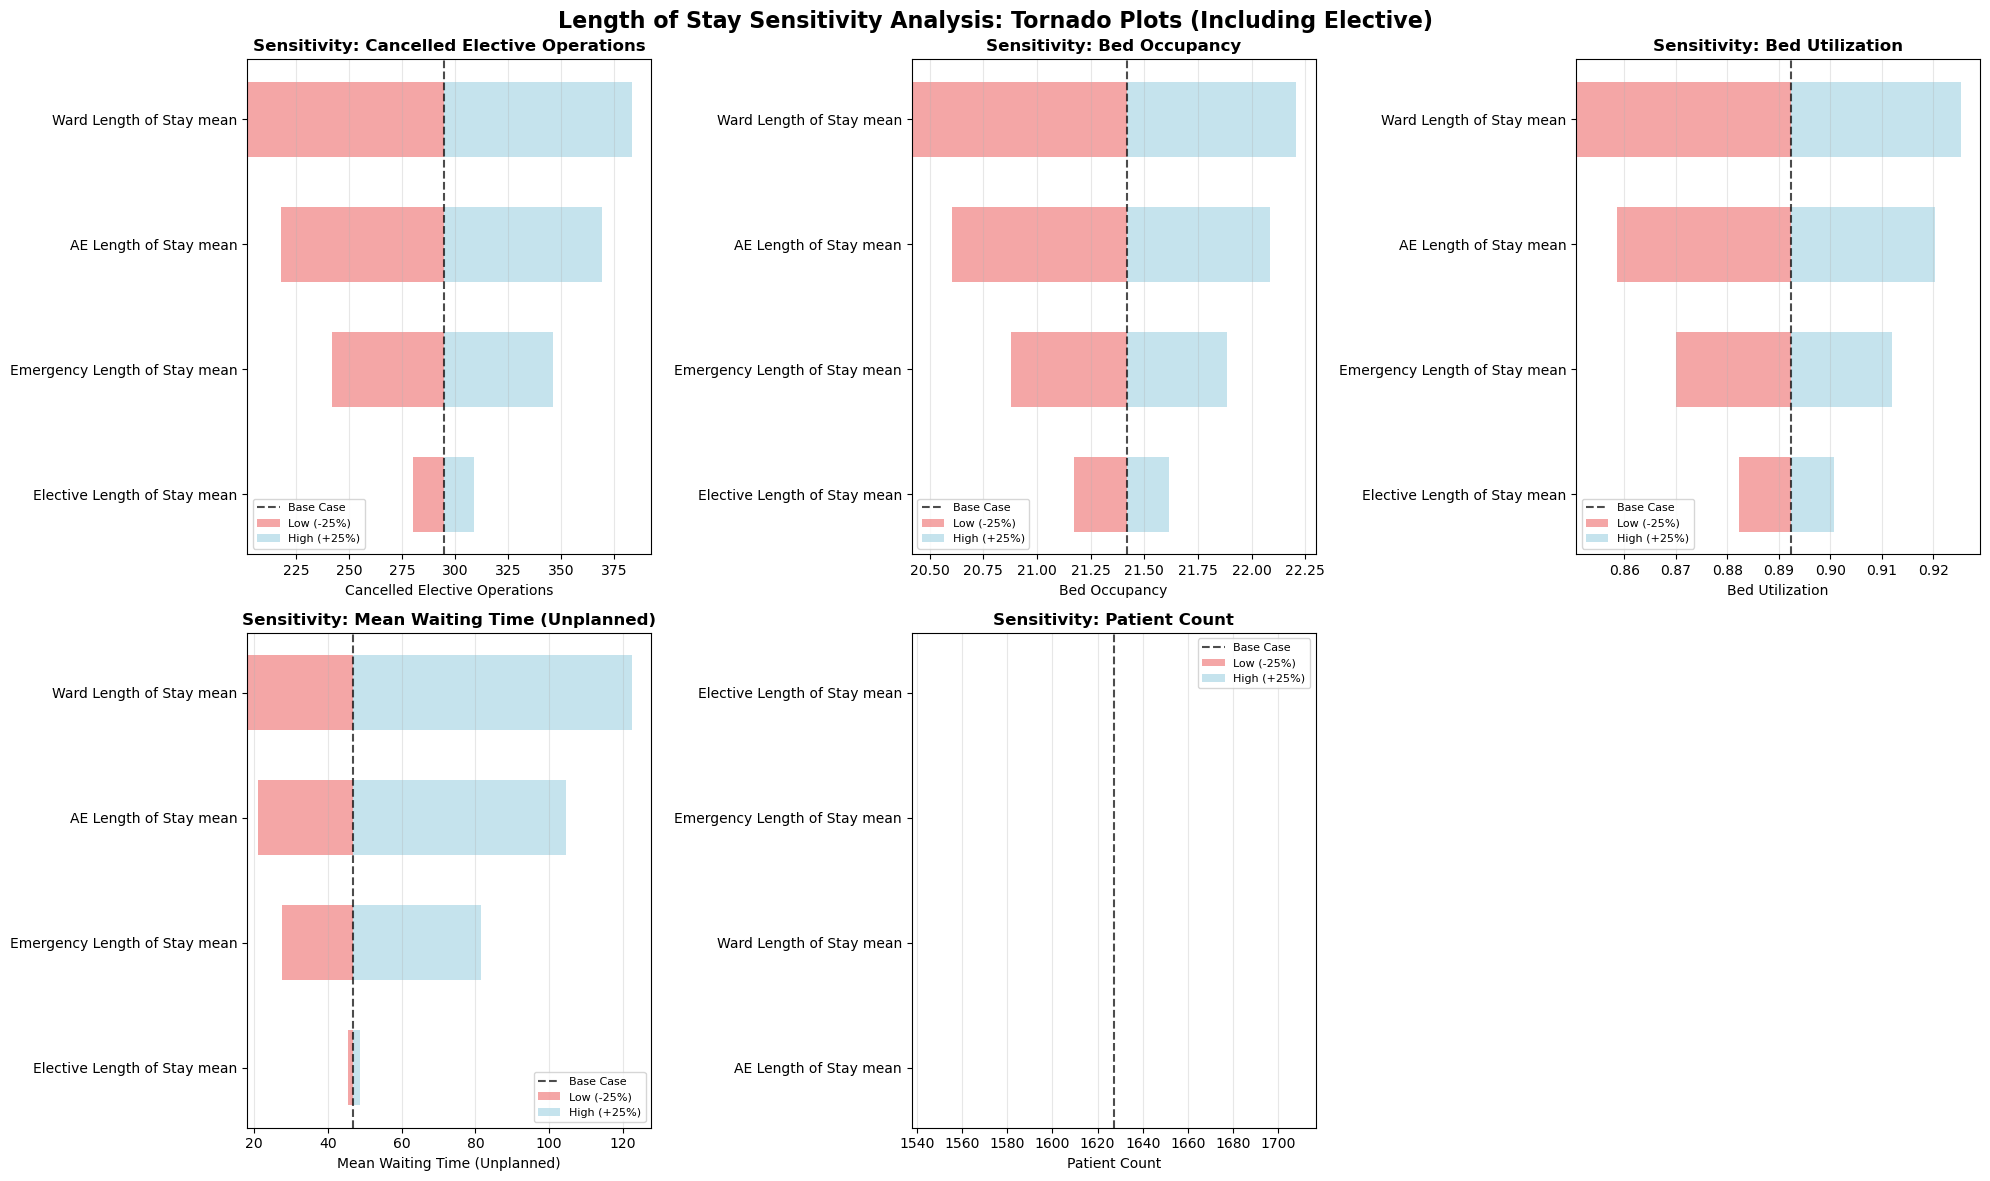


Analysis complete!
Results saved to 'los_sensitivity_analysis_with_elective_results.csv'
Tornado plots saved to 'los_tornado_plots_with_elective.png'

PARAMETER COMPARISON TABLE


,Parameter,Base_LOS_hrs,Low_LOS_hrs,High_LOS_hrs,Low_Cancelled_Ops,High_Cancelled_Ops,Low_Bed_Occupancy,High_Bed_Occupancy
0,AE Length of Stay mean,Base,96.6,161.0,218.0 (-76.9),369.4 (+74.5),20.6 (-0.8),22.1 (+0.7)
1,Ward Length of Stay mean,Base,133.4,222.4,202.2 (-92.7),383.3 (+88.4),20.4 (-1.0),22.2 (+0.8)
2,Emergency Length of Stay mean,Base,105.1,175.2,242.0 (-53.0),346.0 (+51.1),20.9 (-0.5),21.9 (+0.5)
3,Elective Length of Stay mean,Base,43.0,71.7,280.3 (-14.6),309.1 (+14.2),21.2 (-0.2),21.6 (+0.2)


In [7]:
# run the analysis
results = run_los_sensitivity_analysis()

# Create and display comparison table
print("\n" + "=" * 100)
print("PARAMETER COMPARISON TABLE")
print("=" * 100)
comparison_table = create_los_comparison_table(results)
comparison_table

## Analysis 3: Two-way sensitivity analysis

In [8]:
def two_way_sensitivity_analysis():
    """
    2-way sensitivity analysis: Elective inter-arrival time vs Elective length of stay
    """
    # Define parameter ranges
    # Elective inter-arrival time: increase only (reduce patient volume)
    elective_iat_values = np.arange(20, 56, 5)  # [18, 21, 24, 27, 30, 33] hours

    # Elective length of stay: vary both ways (±30%)
    base_elective_los = 57.34
    elective_los_values = np.arange(
        base_elective_los * 0.3,  # 40.1 hours
        base_elective_los * 1.3 + 5,  # 79.5 hours
        6,  # step size
    )

    print("2-Way Sensitivity Analysis: Elective IAT vs Elective LOS")
    print(f"Elective Inter-arrival Times: {elective_iat_values}")
    print(f"Elective Length of Stay: {np.round(elective_los_values, 1)}")
    print(f"Total combinations: {len(elective_iat_values) * len(elective_los_values)}")

    # Base parameters
    base_params = {
        "interarrival_means": [22.72, 26.0, 37.0, 47.2, 575.0, 17.91],
        "stay_distributions": [
            (128.79, 267.51),  # A&E
            (177.89, 276.54),  # Ward
            (140.15, 218.02),  # Emergency surgery
            (212.86, 457.67),  # Other hospitals
            (87.53, 108.67),  # X-ray
            57.34,  # Elective surgery (not used in stay_distributions)
        ],
        "num_critical_care_beds": 24,
        "intensive_cleaning_duration": 5,
        "elective_treatment_mean": 57.34,
    }

    # Store results
    results = []

    # Run experiments for all combinations
    total_experiments = len(elective_iat_values) * len(elective_los_values)
    experiment_count = 0

    for iat, los in product(elective_iat_values, elective_los_values):
        experiment_count += 1
        print(
            f"Running experiment {experiment_count}/{total_experiments}: IAT={iat:.1f}, LOS={los:.1f}"
        )

        # Create modified parameters
        modified_iat_means = base_params["interarrival_means"].copy()
        modified_iat_means[5] = iat  # Update elective inter-arrival time

        # Create experiment
        experiment = Experiment(
            interarrival_means=modified_iat_means,
            stay_distributions=base_params["stay_distributions"],
            num_critical_care_beds=base_params["num_critical_care_beds"],
            intensive_cleaning_duration=base_params["intensive_cleaning_duration"],
            elective_treatment_mean=los,
        )

        # Run replications
        replications = multiple_replications(experiment, num_replications=50)
        summary = results_summary(replications)

        # Store results
        result = {
            "Elective_IAT": iat,
            "Elective_LOS": los,
            "Cancelled_Ops": summary.loc["Cancelled Elective Operations", "Mean"],
            "Cancelled_Ops_Std": summary.loc[
                "Cancelled Elective Operations", "Standard Deviation"
            ],
            "Bed_Occupancy": summary.loc["Bed Occupancy", "Mean"],
            "Bed_Occupancy_Std": summary.loc["Bed Occupancy", "Standard Deviation"],
            "Bed_Utilization": summary.loc["Bed Utilization", "Mean"],
            "Bed_Utilization_Std": summary.loc["Bed Utilization", "Standard Deviation"],
            "Wait_Time": summary.loc["Mean Waiting Time Unplanned", "Mean"],
            "Wait_Time_Std": summary.loc[
                "Mean Waiting Time Unplanned", "Standard Deviation"
            ],
            "Patient_Count": summary.loc["Patient Count", "Mean"],
            "Patient_Count_Std": summary.loc["Patient Count", "Standard Deviation"],
        }
        results.append(result)

    return pd.DataFrame(results), elective_iat_values, elective_los_values

In [9]:
def create_2way_heatmaps(results_df, iat_values, los_values):
    """
    Create heatmaps for 2-way sensitivity analysis
    """
    # Metrics to visualize
    metrics = [
        "Cancelled_Ops",
        "Bed_Occupancy",
        "Bed_Utilization",
        "Wait_Time",
        "Patient_Count",
    ]
    metric_titles = [
        "Cancelled Elective Operations",
        "Bed Occupancy",
        "Bed Utilization",
        "Mean Waiting Time (Unplanned)",
        "Patient Count",
    ]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    # Reference values (Griffith's results)
    reference_values = {
        "Cancelled_Ops": 57,
        "Bed_Occupancy": 19.76,
        "Patient_Count": 1400,
    }

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        if i < len(axes):
            ax = axes[i]

            # Create pivot table for heatmap
            pivot_data = results_df.pivot(
                index="Elective_LOS", columns="Elective_IAT", values=metric
            )

            # Create heatmap
            sns.heatmap(
                pivot_data,
                annot=True,
                fmt=".1f",
                cmap="RdYlBu_r",
                ax=ax,
                cbar_kws={"label": title},
            )

            # Add reference line if available
            if metric in reference_values:
                # Add text annotation for reference value
                ax.text(
                    0.02,
                    0.98,
                    f"Griffith's: {reference_values[metric]}",
                    transform=ax.transAxes,
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment="top",
                )

            ax.set_title(f"{title}", fontsize=12, fontweight="bold")
            ax.set_xlabel("Elective Inter-Arrival Time (hours)")
            ax.set_ylabel("Elective Length of Stay (hours)")

    # Remove unused subplot
    if len(metrics) < len(axes):
        axes[-1].remove()

    plt.suptitle(
        "2-Way Sensitivity Analysis: Elective Inter-Arrival Time vs Length of Stay",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()

    return fig

In [10]:
def create_contour_plots(results_df, iat_values, los_values):
    """
    Create contour plots for 2-way sensitivity analysis
    """
    # Key metrics for contour plots
    metrics = ["Cancelled_Ops", "Bed_Occupancy", "Patient_Count"]
    metric_titles = ["Cancelled Elective Operations", "Bed Occupancy", "Patient Count"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Create meshgrid for contour plots
    IAT, LOS = np.meshgrid(iat_values, los_values)

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        ax = axes[i]

        # Create pivot table
        pivot_data = results_df.pivot(
            index="Elective_LOS", columns="Elective_IAT", values=metric
        )

        # Create contour plot
        contour = ax.contourf(IAT, LOS, pivot_data.values, levels=15, cmap="RdYlBu_r")
        contour_lines = ax.contour(
            IAT,
            LOS,
            pivot_data.values,
            levels=15,
            colors="black",
            alpha=0.4,
            linewidths=0.5,
        )

        # Add contour labels
        ax.clabel(contour_lines, inline=True, fontsize=8)

        # Add colorbar
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label(title)

        ax.set_title(f"{title}", fontsize=12, fontweight="bold")
        ax.set_xlabel("Elective Inter-Arrival Time (hours)")
        ax.set_ylabel("Elective Length of Stay (hours)")
        ax.grid(True, alpha=0.3)

    plt.suptitle(
        "2-Way Sensitivity Analysis: Contour Plots", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()

    return fig

In [11]:
def create_summary_table(results_df):
    """
    Create summary statistics table
    """
    summary_stats = []

    metrics = [
        "Cancelled_Ops",
        "Bed_Occupancy",
        "Bed_Utilization",
        "Wait_Time",
        "Patient_Count",
    ]
    metric_names = [
        "Cancelled Elective Operations",
        "Bed Occupancy",
        "Bed Utilization",
        "Mean Waiting Time (Unplanned)",
        "Patient Count",
    ]

    for metric, name in zip(metrics, metric_names):
        min_val = results_df[metric].min()
        max_val = results_df[metric].max()
        mean_val = results_df[metric].mean()
        std_val = results_df[metric].std()

        # Find conditions for min and max
        min_condition = results_df[results_df[metric] == min_val].iloc[0]
        max_condition = results_df[results_df[metric] == max_val].iloc[0]

        summary_stats.append(
            {
                "Metric": name,
                "Min_Value": f"{min_val:.1f}",
                "Min_Condition": f"IAT={min_condition['Elective_IAT']:.1f}, LOS={min_condition['Elective_LOS']:.1f}",
                "Max_Value": f"{max_val:.1f}",
                "Max_Condition": f"IAT={max_condition['Elective_IAT']:.1f}, LOS={max_condition['Elective_LOS']:.1f}",
                "Mean": f"{mean_val:.1f}",
                "Std": f"{std_val:.1f}",
            }
        )

    return pd.DataFrame(summary_stats)

In [12]:
def run_2way_sensitivity_analysis():
    """
    Main function to run 2-way sensitivity analysis
    """
    print("Starting 2-Way Sensitivity Analysis...")
    print("This may take some time due to the number of combinations...")

    # Run the analysis
    results_df, iat_values, los_values = two_way_sensitivity_analysis()

    # Create visualizations
    print("\nCreating heatmaps...")
    heatmap_fig = create_2way_heatmaps(results_df, iat_values, los_values)

    print("Creating contour plots...")
    contour_fig = create_contour_plots(results_df, iat_values, los_values)

    # Create summary table
    print("Creating summary table...")
    summary_table = create_summary_table(results_df)

    print("\n" + "=" * 100)
    print("2-WAY SENSITIVITY ANALYSIS SUMMARY")
    print("=" * 100)
    print(summary_table.to_string(index=False))

    # Show plots
    plt.show()

    # Save results
    results_df.to_csv("2way_sensitivity_analysis_results.csv", index=False)
    summary_table.to_csv("2way_sensitivity_summary.csv", index=False)
    heatmap_fig.savefig("2way_sensitivity_heatmaps.png", dpi=300, bbox_inches="tight")
    contour_fig.savefig("2way_sensitivity_contours.png", dpi=300, bbox_inches="tight")

    print("\nAnalysis complete!")
    print("Files saved:")
    print("- 2way_sensitivity_analysis_results.csv")
    print("- 2way_sensitivity_summary.csv")
    print("- 2way_sensitivity_heatmaps.png")
    print("- 2way_sensitivity_contours.png")

    return results_df, summary_table

Starting 2-Way Sensitivity Analysis...
This may take some time due to the number of combinations...
2-Way Sensitivity Analysis: Elective IAT vs Elective LOS
Elective Inter-arrival Times: [20 25 30 35 40 45 50 55]
Elective Length of Stay: [17.2 23.2 29.2 35.2 41.2 47.2 53.2 59.2 65.2 71.2 77.2]
Total combinations: 88
Running experiment 1/88: IAT=20.0, LOS=17.2
Running experiment 2/88: IAT=20.0, LOS=23.2
Running experiment 3/88: IAT=20.0, LOS=29.2
Running experiment 4/88: IAT=20.0, LOS=35.2
Running experiment 5/88: IAT=20.0, LOS=41.2
Running experiment 6/88: IAT=20.0, LOS=47.2
Running experiment 7/88: IAT=20.0, LOS=53.2
Running experiment 8/88: IAT=20.0, LOS=59.2
Running experiment 9/88: IAT=20.0, LOS=65.2
Running experiment 10/88: IAT=20.0, LOS=71.2
Running experiment 11/88: IAT=20.0, LOS=77.2
Running experiment 12/88: IAT=25.0, LOS=17.2
Running experiment 13/88: IAT=25.0, LOS=23.2
Running experiment 14/88: IAT=25.0, LOS=29.2
Running experiment 15/88: IAT=25.0, LOS=35.2
Running experime

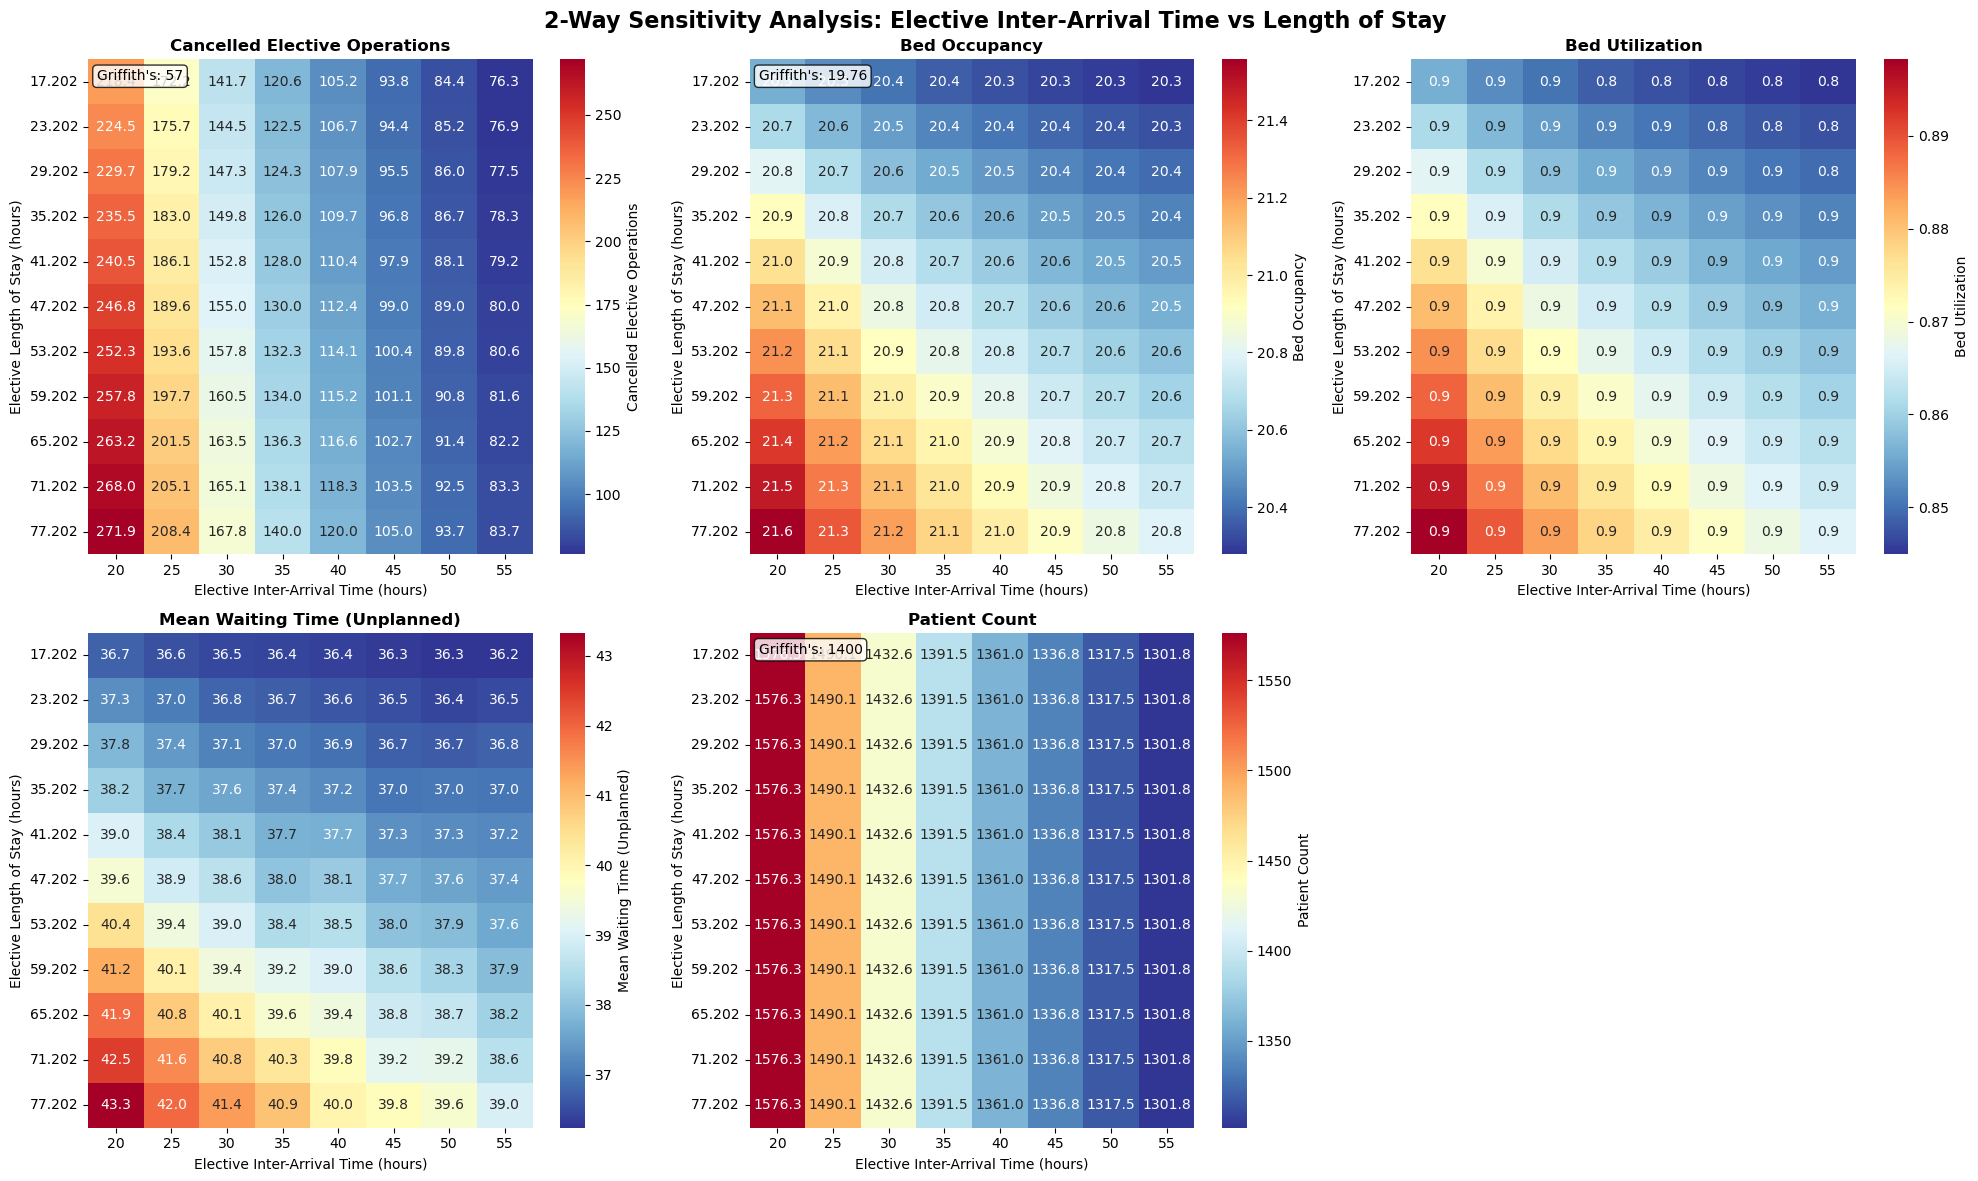

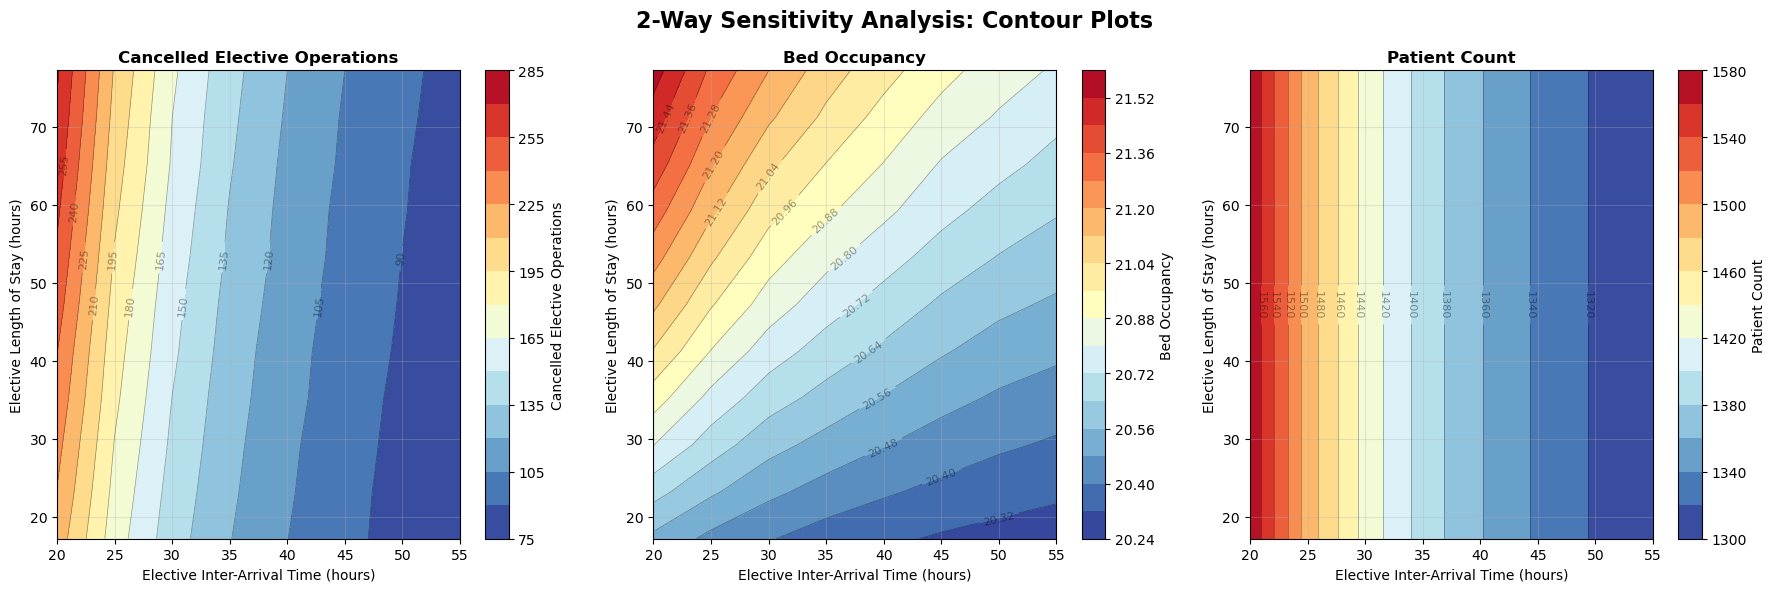


Analysis complete!
Files saved:
- 2way_sensitivity_analysis_results.csv
- 2way_sensitivity_summary.csv
- 2way_sensitivity_heatmaps.png
- 2way_sensitivity_contours.png


In [13]:
results, summary = run_2way_sensitivity_analysis()

In [14]:
summary

,Metric,Min_Value,Min_Condition,Max_Value,Max_Condition,Mean,Std
0,Cancelled Elective Operations,76.3,"IAT=55.0, LOS=17.2",271.9,"IAT=20.0, LOS=77.2",137.8,54.3
1,Bed Occupancy,20.3,"IAT=55.0, LOS=17.2",21.6,"IAT=20.0, LOS=77.2",20.8,0.3
2,Bed Utilization,0.8,"IAT=55.0, LOS=17.2",0.9,"IAT=20.0, LOS=77.2",0.9,0.0
3,Mean Waiting Time (Unplanned),36.2,"IAT=55.0, LOS=17.2",43.3,"IAT=20.0, LOS=77.2",38.4,1.6
4,Patient Count,1301.8,"IAT=55.0, LOS=17.2",1576.3,"IAT=20.0, LOS=17.2",1400.9,88.7
